## Scratch

In [12]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec


from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data
from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                           plot_interpolations

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  


from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud, Mesh
import geo_tool.solids.mesh_cleaning as cleaning

import tf_lab.autopredictors.scripts.virt_scan_data as vscan

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [48]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
from scipy.io import loadmat
mit_data = '/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/mit_3dgan_1K_synthetic_samples/chair_sample.mat'
mit_data = loadmat(mit_data)

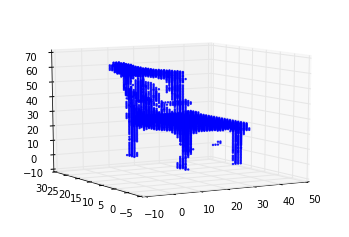

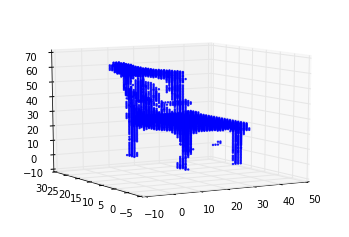

In [22]:
one_example = mit_data['voxels'][12][0] 
one_example[one_example < 0.2] = 0

x, y, z = np.where(one_example)
points = np.vstack((x, y, z)).T
Point_Cloud(points=points).plot()


In [90]:
data = np.load('/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/raw_gan_panos_v1.npz')
data = data[data.keys()[0]]

data_2 = np.empty_like(data)
for i, pc in enumerate(data):
    data_2[i] = pc[:, [0,2,1]]
    

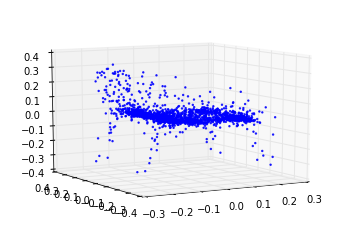

In [91]:
pc = Point_Cloud(data[2])
pc.plot();
# Point_Cloud(data_2[0]).plot()

In [92]:
np.savez('/orions4-zfs/projects/lins2/Panos_Space/DATA/NIPS/our_samples/raw_gan_panos_v1_rotated.npz', data_2)